## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

D:\AnacondaGO\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)

fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_dataset, val_dataset = torch.utils.data.random_split(fmnist_dataset_train, [int(len(fmnist_dataset_train)*0.8), int(len(fmnist_dataset_train)*0.2)])

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test), len(train_dataset), len(val_dataset)

(10000, 48000, 12000)

In [7]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [8]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape * input_channels, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [9]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 204,042
Trainable params: 204,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.78
Estimated Total Size (MB): 0.80
----------------------------------------------------------------


In [25]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

Your experiments come here:

In [26]:
model1 = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model1.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss() # it's include softmax, before calculatin cross entropy 

# Your experiments, training and validation loops here

In [27]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            opt.zero_grad() # torch add grad, so we need make them zero every step
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step() 
            
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                
                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [28]:
train_loss, val_loss, val_accuracy = train_model(model1, train_loader, val_loader, loss_func, opt, 15)

Epoch 1 of 15 took 20.779s
	  training loss: 0.541707
	validation loss: 0.424363
	validation accuracy: 0.847
Epoch 2 of 15 took 18.217s
	  training loss: 0.416473
	validation loss: 0.394756
	validation accuracy: 0.861
Epoch 3 of 15 took 17.641s
	  training loss: 0.382164
	validation loss: 0.374115
	validation accuracy: 0.867
Epoch 4 of 15 took 18.707s
	  training loss: 0.363350
	validation loss: 0.362570
	validation accuracy: 0.870
Epoch 5 of 15 took 17.808s
	  training loss: 0.348528
	validation loss: 0.359719
	validation accuracy: 0.873
Epoch 6 of 15 took 18.111s
	  training loss: 0.335794
	validation loss: 0.351718
	validation accuracy: 0.873
Epoch 7 of 15 took 18.980s
	  training loss: 0.324982
	validation loss: 0.342123
	validation accuracy: 0.878
Epoch 8 of 15 took 17.082s
	  training loss: 0.312495
	validation loss: 0.345013
	validation accuracy: 0.877
Epoch 9 of 15 took 17.504s
	  training loss: 0.306339
	validation loss: 0.327807
	validation accuracy: 0.883
Epoch 10 of 15 took

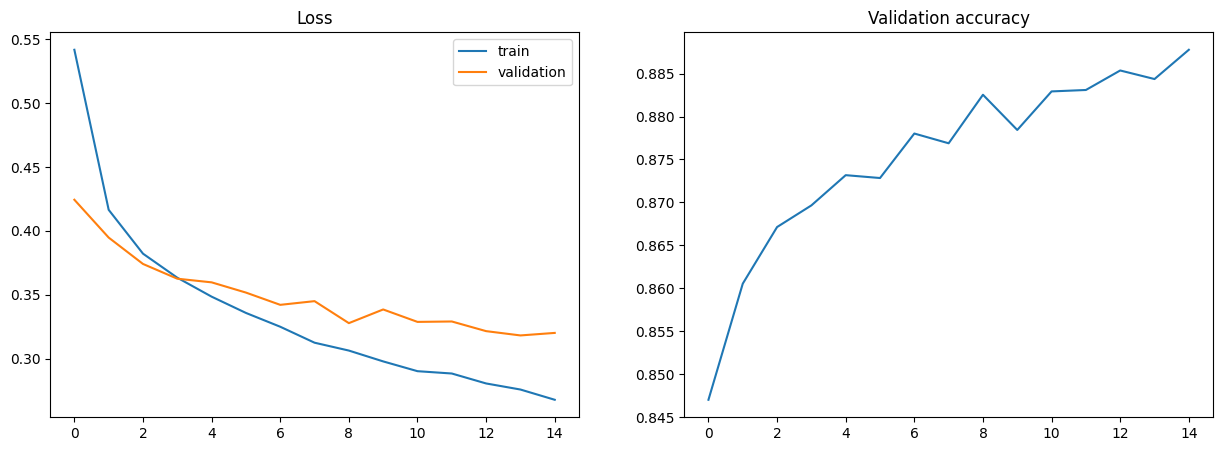

In [30]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [31]:
def test_predict(model, test_loader):
    model.eval() # off Dropout to get more accuracy on test
    acc, batches = 0, 0
    for x_batch, y_batch in test_loader:
        y_pred = model.forward(x_batch.to(device))
        batches += 1
        acc += (y_pred.cpu().max(1)[1].data == y_batch.cpu()).numpy().mean()
    return (acc/batches)

In [32]:
test_predict(model1, test_loader)

0.8853515625

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [17]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            # therea are problem with tanh (or sigmoid) func activation, if we have lot of layers, then on first layers we will have 
            # small gradient because differential of tanh <1, so weight will changes only on last layers
            # https://www.youtube.com/watch?v=jy6Dz4I5WHc

            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape * input_channels, 512),
            #nn.BatchNorm1d(512), # for 2d and 3d input 
            nn.ReLU(),  # Batch norm better use before activation, but there is no consensus
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)

            # Dropout (for regularization), it dropout some of inputs in layer
            # default parametr p = 0.5 - the probability of deleting an input, i.e. 0.5 means that we will delete half of the inputs
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [18]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                 [-1, 1024]         525,312
              ReLU-5                 [-1, 1024]               0
            Linear-6                   [-1, 10]          10,250
Total params: 937,482
Trainable params: 937,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.58
Estimated Total Size (MB): 3.61
----------------------------------------------------------------


In [19]:
model2 = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model2.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss() # it's include softmax, before calculatin cross entropy 

In [20]:
train_loss_2, val_loss_2, val_accuracy_2 = train_model(model2, train_loader, test_loader, loss_func, opt, 20)

Epoch 1 of 20 took 25.114s
	  training loss: 0.533676
	validation loss: 0.408251
	validation accuracy: 0.851
Epoch 2 of 20 took 25.883s
	  training loss: 0.368449
	validation loss: 0.411443
	validation accuracy: 0.851
Epoch 3 of 20 took 25.635s
	  training loss: 0.330862
	validation loss: 0.359177
	validation accuracy: 0.868
Epoch 4 of 20 took 24.475s
	  training loss: 0.305957
	validation loss: 0.380110
	validation accuracy: 0.865
Epoch 5 of 20 took 25.922s
	  training loss: 0.284623
	validation loss: 0.334867
	validation accuracy: 0.882
Epoch 6 of 20 took 27.229s
	  training loss: 0.266869
	validation loss: 0.347750
	validation accuracy: 0.874
Epoch 7 of 20 took 26.472s
	  training loss: 0.252449
	validation loss: 0.349275
	validation accuracy: 0.880
Epoch 8 of 20 took 25.636s
	  training loss: 0.240073
	validation loss: 0.361873
	validation accuracy: 0.876
Epoch 9 of 20 took 25.604s
	  training loss: 0.230838
	validation loss: 0.328154
	validation accuracy: 0.890
Epoch 10 of 20 took

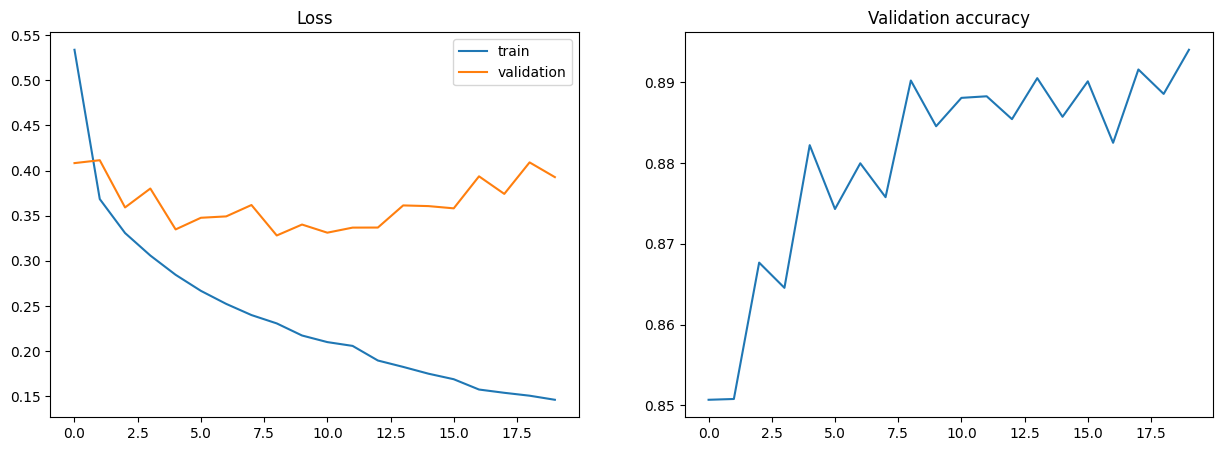

In [21]:
plot_train_process(train_loss_2, val_loss_2, val_accuracy_2)

In [22]:
test_predict(model2, test_loader)

0.89404296875

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [41]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(input_shape * input_channels, 256),
            nn.BatchNorm1d(256), # for 2d and 3d input 
            nn.ReLU(),  # Batch norm better use before activation, but there is no consensus
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [42]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 256]         200,960
       BatchNorm1d-4                  [-1, 256]             512
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                  [-1, 512]         131,584
       BatchNorm1d-8                  [-1, 512]           1,024
              ReLU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                   [-1, 10]           5,130
Total params: 339,210
Trainable params: 339,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [43]:
model3 = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model3.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss() # it's include softmax, before calculatin cross entropy 
# Your experiments, come here

In [44]:
train_loss_3, val_loss_3, val_accuracy_3 = train_model(model3, train_loader, test_loader, loss_func, opt, 25)

Epoch 1 of 25 took 19.341s
	  training loss: 0.654915
	validation loss: 0.460982
	validation accuracy: 0.828
Epoch 2 of 25 took 21.286s
	  training loss: 0.502912
	validation loss: 0.411014
	validation accuracy: 0.851
Epoch 3 of 25 took 19.331s
	  training loss: 0.471665
	validation loss: 0.387803
	validation accuracy: 0.858
Epoch 4 of 25 took 19.848s
	  training loss: 0.449270
	validation loss: 0.383477
	validation accuracy: 0.860
Epoch 5 of 25 took 19.522s
	  training loss: 0.435489
	validation loss: 0.368765
	validation accuracy: 0.864
Epoch 6 of 25 took 19.458s
	  training loss: 0.421898
	validation loss: 0.359052
	validation accuracy: 0.866
Epoch 7 of 25 took 19.636s
	  training loss: 0.408154
	validation loss: 0.359467
	validation accuracy: 0.870
Epoch 8 of 25 took 19.433s
	  training loss: 0.404099
	validation loss: 0.352273
	validation accuracy: 0.871
Epoch 9 of 25 took 21.753s
	  training loss: 0.398931
	validation loss: 0.350423
	validation accuracy: 0.872
Epoch 10 of 25 took

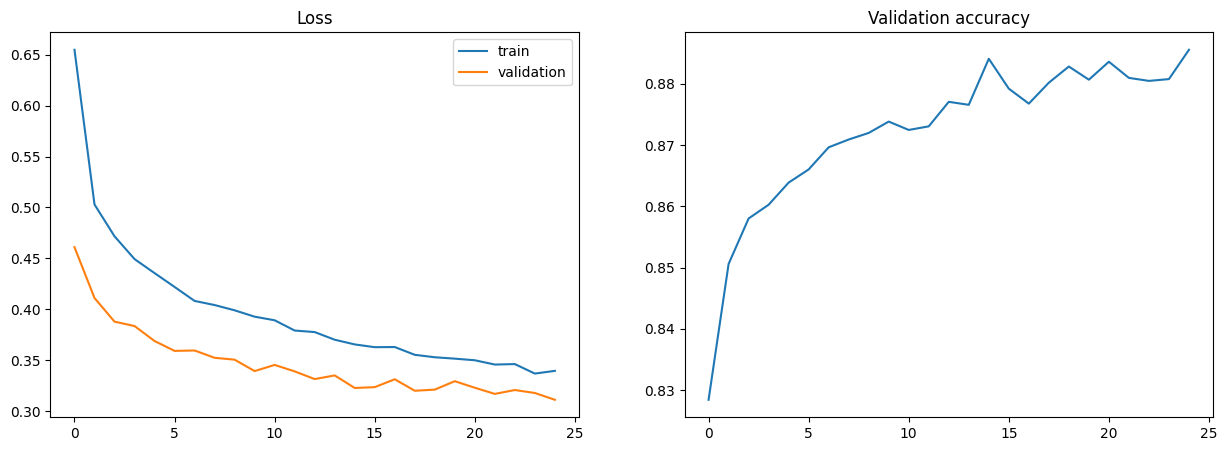

In [45]:
plot_train_process(train_loss_3, val_loss_3, val_accuracy_3)

In [46]:
test_predict(model3, test_loader)

0.885546875

### Conclusions:
_Write down small report with your conclusions and your ideas._

### Firstly I needed make some change in  Tiny model to get score 0.885 and more 

### The easiest part was overfitting the model, i just increase number of layers and their dimensions. And we can see how training loss decreases and validation loss rising

### Last part, for fix overfitting i used dropout before Linear layers and validate number epochs. In addition, rationing helped to stabilize the stability of the algorithm

### But as we see our first simple model already get necessary accuracy, so sometimes complicated model not the best (But comlicated should be more stability on tests)

### And last interesting point, on overfitting model we get best accuracy sсore on test. We have achieved mean 89 percent accuracy on validation and this is enough for a good prediction on the test